## Exploring Machine Learning Basics

by implementing a k-nearest neighbors classifier and applying it to the iris dataset.

The k-nearest neighbors (Knn) algorithm is a supervised classification algorithm. It is differs from many other classification algorithms by almost not having any parameters that are 'learned' during training. Training a Knn involves providing training data consisting of an array of feature-vectors and an array of labels which are merely saved internally to be used later for predictions. To classify a new instance given as an feature-vector the distance of the new feature-vector to each of the previously saved feature-vectors is calculated. This step determines how close every neighbor of the new instance is to the new instance. Now the 'k' in Knn comes in. K is a parameter determinig how many of these neighbors are selected. From the selected set of instances the saved labels are looked up and the label that is most common within the selection is assigned to the new instance and returned by the classifier.

The choice of k is the only explicit parameter to this algorithm. It determines how many of the nearest neighbors instances will be considered for voting on a classification. Small values for k tend to be more affected by noise in the training data, while large k-values might miss minute but significant patterns within the data.

The assumption behind the distance-metric is that feature-vectors which are close in terms of distance are similiar and therefore are likely to belong to the same class. Chossing the distance metric is somewhat arbitrary - the euclidean distance is pretty commonly used, but is not perfect either. For example this metric does not differntiate along which dimension the distances accumulate, assigning every dimension equal weight - which will not always be correct.   

In [18]:
%matplotlib inline
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

### Iris Dataset

The iris dataset contains data describing the width and height of the sepal and petal of three types of irises' - Setosa, Versicolour, and Virginica. More information can be found on the [Scikit-learn page](http://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html)

In [21]:
iris = datasets.load_iris()

### Train Test Split

Evaluating the classifier by having it classify the training data is usually a bad idea, because one will not be able to detect [overfitting](https://en.wikipedia.org/wiki/Overfitting)

For a nearest neighbor classifier this is particular relevant, as testing using training data means that there will always exist an instance with zero distance already.

A train-test-split randomly shuffles the training data and then uses a fraction of the data for training and the rest for testing the classifier. The benefit is that the test data should be more representative of real-world-data which the classifier will encouter later on.

For reproducability the random_state is fixed, otherwise the results will differ between runs.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(iris.data,
                                                    iris.target,
                                                    test_size=0.25,
                                                    random_state=0)

# number of training and testing examples
len(X_train), len(X_test)

(112, 38)

### Knn Implementation

In [23]:
class Knn:
    def __init__(self, k=5):
        """
        k-nearest-neighbor classifier. The programming interface is
        based on scikit-learn, featuring 'fit(X, y)' to train the classifier
        and 'predict(X)' to get predictions from the algorithm.
        
        Parameters
        ----------
        k : positive integer
            the number of objects to be considered for 
            majority vote during classification.
        
        Example
        -------
        >>> clf = Knn(5)
        ### Provide training data
        >>> clf.fit(X_train, y_train)
        ### Get predictions from the classifier
        >>> clf.predict(X_test) 
        ### returns an element of y_train
        """
        # call the property setter
        # who does the verification
        self.k = k
        
    def _check_parameter(self, k):
        if k <= 0:
            raise ValueError("Knn parameter 'k' must be positive")
        
    @property
    def k(self):
        return self._k
    
    @k.setter
    def k(self, k):
        self._check_parameter(k)
        self._k = int(k)
        
    def _majority_vote(self, idx):
        """
        Given the indexes of the k nearest neighbors
            determine the most common label.
        
        Parameters
        ----------
        idx : array-like
            Every element of idx should be a valid index into X provided
            in the self.fit(X, y) function.
            
        Returns
        -------
        y[n] : label (element of y (from self.fit(X, y)))
            The element of y that is most frequent within the selected
            indices.
        """
        ctr = Counter(self._y_train[idx])
        # Counter.most_common returns a list of the '1' most common object
        # every entry of the list is a two-tuple with (object, count)
        return ctr.most_common(1)[0][0]
        
    def fit(self, X_train, y_train):
        """ 'Fit' the classifier to the data. For a knn this means
            keeping a copy of it around for later reference.
        
        Parameters
        ----------
        X_train : array-like
            array containing the featurevectors of every object
        y_train : array-like
            array containing the labels of every object
        
            for any 'i' X_train[i] should correspond to y_train[i].
            
        Returns
        -------
            self 
            # eg. for self.fit(X_train, y_train).predict(X_test)
        """
        # the array constructor ensures the existance of numpy arrays
        # (rather than python lists) within this instance and will create a 
        # copy of the trianing data that is uneffected by future 'outside'
        # manipulations
        self._X_train = np.array(X_train)
        self._y_train = np.array(y_train)
        return self
    
    def predict(self, X_pred, k = None):
        """ 'Predict' a label for every feature vector and return it.
                
        Parameters
        ----------
        X_pred : array-like
            array containing the featurevectors of every object
        k : positive integer
            the number of objects to be considered for 
            majority vote during classification.
        
        Example
        -------
        >>> clf = Knn(5)
        ### Provide training data
        >>> clf.fit(X_train, y_train)
        ### Get predictions from the classifier
        >>> clf.predict(X_pred)
        ### returns a vector y
                    
        Returns
        -------
        y : array-like
            for all i y[i] contains the prediction for X_test[i]
            all elements of y are taken from y_train
    
        
        Complexity
        ----------
            O(len(X_test)*len(X_train))
        """
        if k is None:
            k = self._k
        self._check_parameter(k)
        
        out = []
        # ensure that the input X is at least two dimensional
        # i.e. a list of feature vectors
        # This is necesary for when X is a single feature vector.
        X = np.atleast_2d(X_pred)
        
        for x in X:
            # given a single feature vector (x)
            # determine the label of the example
            # based on majority vote of the nearest neighbors

            # vector of elementwise distances
            dist = np.linalg.norm(self._X_train - x, axis=1)
            
            # get the indexes of the k smallest instances
            idx = np.argsort(dist)[:int(k)]
            
            # pass the nearest neighbors to the majority vote
            # to determine the label
            out.append(self._majority_vote(idx))
            
        return np.array(out)
    
    def accuracy(self, X_test, y_test, k = None):
        """ Evaluate the accuracy of the classifier
                
        Parameters
        ----------
        X_test : array-like
            array containing the feature vectors of every instance
        y_test : array-like
            array containig the ground truth labels of every instance 
        k : positive integer
            the number of objects to be considered for 
            majority vote during classification.
        
        Example
        -------
        >>> clf = Knn(5)
        ### Provide training data
        >>> clf.fit(X_train, y_train)
        ### Get predictions from the classifier
        >>> print(clf.accuracy(X_test, y_test))
                    
        Returns
        -------
        accuracy : number in [0, 1]
            the fraction of correct predictions over all predictions made
    
        
        Complexity
        ----------
            O(len(X_test)*len(X_train))
        """
        return np.mean(self.predict(X_test, k) == y_test)

### Evaluating Accuracy and Overfitting

The accuracy of a classifier is the fraction of correct predictions over all predictions made. A small number means lots of misclassifications while a number close to one is desireable.

In [25]:
clf = Knn(k=5)
clf.fit(X_train, y_train)

# KNN (k=5) Accuracy on test data
clf.accuracy(X_test, y_test)

0.97368421052631582

In [26]:
# KNN (k=5) Accuracy on training data
clf.accuracy(X_test, y_test)

0.97368421052631582

There is no difference between trainig and testing accuracy in this case - hinting that overfitting is not a big problem. To further investigate the question of whether the classifier overfits, we will consider a range of values for k inbetween 1 and 100 and plot the accuracy.

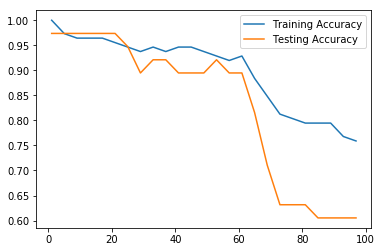

In [27]:
r = range(1, 100, 4)
train_acc = [clf.accuracy(X_train, y_train, k) for k in r]
test_acc  = [clf.accuracy(X_test,  y_test,  k) for k in r]

plt.plot(r, train_acc)
plt.plot(r, test_acc)
plt.legend(['Training Accuracy', 'Testing Accuracy'])

With this split of the iris dataset, the testing accuracy is stable for k smaller than 20. The training accuracy decreases from 1 to 10, hinting at less overfitting with k equal to 10 rather than 1.
For three possible classes, a random classification (guessing) would be expected be right in a third of the cases, resulting in an accuracy of 0.33. As can be seen from the graph, for increasing values of k the KNN classifier experiences a degradation in performance, but remains better than random.

### Exploring the errors made

For debugging and optimization it is helpful to know if there are certain errors the classifier makes frequently. This can be seen from a confusion matrix. On the vertical the groundtruth label is plotted and the predicted labels are along the horizontal axis. In the confusion matrix the entry C[i, j] corresponds to how often the classifier classifies an instance that is in i-th class as belonging to the j-th class. If the classifier is perfect, all predicted labels equal their corresponding groundtruth labels and the confusion matrix has all non-zero values on the diagonal. Errors show themselfs as non-zero values in elements not on the diagonal.

Confusion Matrix:
 [[13  0  0]
 [ 0 15  1]
 [ 0  0  9]]


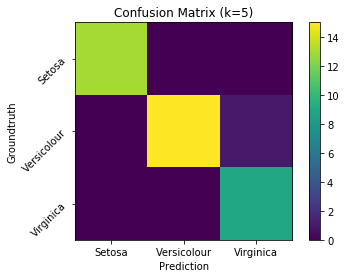

In [28]:
labels = ["Setosa", "Versicolour", "Virginica"]
C = confusion_matrix(y_test, clf.predict(X_test))
print("Confusion Matrix:\n", C)

plt.imshow(C, interpolation='nearest')
plt.title("Confusion Matrix (k={})".format(clf.k))
tick_marks = np.arange(len(labels))
plt.yticks(tick_marks, labels, rotation=45)
plt.ylabel('Groundtruth')
plt.xticks(tick_marks, labels)
plt.xlabel('Prediction')
plt.colorbar()

In this case the classifier is relative accurate and only makes one mistake. This is in part due to the simplicity of the task but also the relatively large trainingset size (75%) compared to the testset size adds to that.

In [9]:
#